In [1]:
import warnings
warnings.filterwarnings('ignore') # For better visibility, warnings are turned off in this notebook

# Industrial Site

In this application of the FINE framework, an energy supply system, consisting of two-regions, is modeled and optimized.

The workflow is structures as follows:
-  Required packages are imported
-  An energy system model instance is created
-  Commodity sources are added to the energy supply system model
-  Commodity conversion components are added to the energy supply system model
-  Commodity storages are added to the energy supply system model
-  Commodity transmission components are added to the energy supply system model
-  Commodity sinks are added to the energy supply system model
-  The energy supply system model is optimized
-  Selected optimization results are presented

# Import required packages

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [2]:
import FINE as fn         # Provides objects and functions to model an energy system 
import pandas as pd       # Used to manage data in tables
import geopandas as gpd   # Used to display geo-referenced plots
import shapely as shp     # Used to generate geometric objects
import numpy as np        # Used to generate random input data

%load_ext autoreload
%autoreload 2

# Model an energy system

## Specify model configuration

In [ ]:
doDSM = True

## Create an energy system model instance 

The structure of the energy supply system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_naturalGas_lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [3]:
# Input parameters
locations = {'industry_0'}
commodityUnitDict = {'electricity': r'MW$_{el}$', 'hydrogen': r'MW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen'}
numberOfTimeSteps, hoursPerTimeStep = 52560, 1/6 #8760, 1 
costUnit, lengthUnit = '1e3 Euro', 'km'

# Code
esM = fn.EnergySystemModel(locations=locations, commodities=commodities,
    numberOfTimeSteps=numberOfTimeSteps, commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=hoursPerTimeStep, costUnit=costUnit, lengthUnit=lengthUnit, verboseLogLevel=0)

## Add source component

Source components generate commodities across the energy system's virtual boundaries.

In [4]:
data = pd.read_excel('generationTimeSeries_e825103.xlsx')
operationRateMax = pd.DataFrame(data['e825103_2017_2.3MW_faults9'],index=range(numberOfTimeSteps)) # Dataset with least missing data
operationRateMax.columns = ['industry_0']

In [5]:
# Input parameters
name, commodity ='Wind turbines', 'electricity'
hasCapacityVariable = True
capacityFix = pd.Series([20], index=['industry_0']) # 10 MW_el = 0.01 GW_el
investPerCapacity, opexPerCapacity = 0, 30 # 30 €/kW = 30 1e6€/GW = 30 1e3€/MW
interestRate, economicLifetime = 0.08, 20

# Code
esM.add(fn.Source(esM=esM, name=name, commodity=commodity, hasCapacityVariable=hasCapacityVariable,
    operationRateMax=operationRateMax, capacityFix=capacityFix, investPerCapacity=investPerCapacity,
    opexPerCapacity=opexPerCapacity, interestRate=interestRate, economicLifetime=economicLifetime))

In [6]:
operationRateMax.sum()

industry_0    12107.056522
dtype: float64

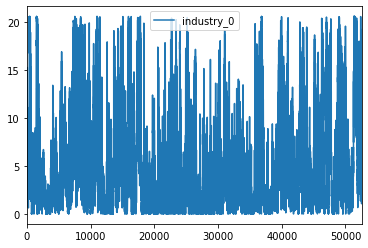

In [7]:
(capacityFix*operationRateMax).plot()

## Add conversion components

In [8]:
esM.add(fn.Conversion(esM=esM, name='PEMEC', physicalUnit=r'MW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.67},
                      hasCapacityVariable=True, 
                      investPerCapacity=2300, opexPerCapacity=12.5, interestRate=0.08, # for 2018 CAPEX
                      economicLifetime=5))

In [9]:
esM.add(fn.Conversion(esM=esM, name='AEC', physicalUnit=r'MW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.64},
                      hasCapacityVariable=True, 
                      investPerCapacity=1300, opexPerCapacity=18, interestRate=0.08, # for 2018 CAPEX
                      economicLifetime=9))

## Add storage components

In [10]:
esM.add(fn.Storage(esM=esM, name='Hydrogen tank (gaseous)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=1,
                   chargeRate=1, dischargeRate=1, sharedPotentialID=None,
                   stateOfChargeMin=0.06, stateOfChargeMax=1,
                   investPerCapacity=0.004, opexPerCapacity=0.004*0.02, interestRate=0.08,
                   economicLifetime=20))

### Industrial hydrogen demand

operationRateFix = pd.DataFrame(2*np.ones(52560)*(1/6), columns=['industry_0']) # constant hydrogen demand of 2 MW_GH2: ATTN
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=operationRateFix))

In [11]:
operationRateFix = pd.DataFrame(2*np.ones(52560)*(1/6), columns=['industry_0']) # constant hydrogen demand of 2 MW_GH2: ATTN
if doDSM:
    esM.add(fn.DemandSideManagement(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                    tUp=1, tDown=1, operationRateFix=operationRateFix))
else:
    esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                    operationRateFix=operationRateFix))

# Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [12]:
# Input parameters
numberOfTypicalPeriods=30
numberOfTimeStepsPerPeriod=24*6

# Code
esM.cluster(numberOfTypicalPeriods=numberOfTypicalPeriods,numberOfTimeStepsPerPeriod=numberOfTimeStepsPerPeriod)


Clustering time series data with 30 typical periods and 144 time steps per period...
		(7.6388 sec)



In [13]:
# Input parameters
timeSeriesAggregation=False
solver='gurobi'

# Code
esM.optimize(timeSeriesAggregation=timeSeriesAggregation, solver=solver)

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(9.5446 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(6.4360 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(15.0121 sec)

Declaring sets, variables and constraints for StorageExtModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(76.2934 sec)

Declaring sets, variables and constraints for DSMModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(7.4982 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(20.5733 sec)

Declaring objective function...
		(12.0284 sec)

Using license file C:\Users\LaraWelder\gurobi.lic
Academic license - for non-commercial use only
Read L

  79   3.51347268e+03 -9.87763519e+03  7.90e-08 1.83e-06  1.33e-02   145s
  80   2.56854018e+03 -5.42108938e+03  1.84e-07 1.14e-06  8.05e-03   147s
  81   2.19939871e+03 -2.54164895e+03  2.76e-07 6.89e-07  4.82e-03   148s
  82   2.03684284e+03 -6.26066659e+02  4.18e-07 3.91e-07  2.72e-03   149s
  83   1.97487193e+03  8.13428488e+02  1.85e-07 1.68e-07  1.19e-03   151s
  84   1.94349663e+03  1.48943876e+03  9.81e-08 6.29e-08  4.64e-04   152s
  85   1.92593626e+03  1.73033035e+03  5.86e-08 2.55e-08  1.99e-04   154s
  86   1.91695372e+03  1.82950004e+03  4.39e-08 1.01e-08  8.77e-05   155s
  87   1.91227778e+03  1.88559092e+03  1.10e-08 1.69e-09  2.61e-05   157s
  88   1.91018688e+03  1.90025721e+03  2.91e-09 8.34e-12  9.53e-06   158s
  89   1.90984345e+03  1.90861185e+03  1.80e-09 8.12e-12  1.17e-06   160s
  90   1.90987884e+03  1.90906665e+03  1.69e-09 7.06e-17  7.68e-07   162s
  91   1.90977077e+03  1.90927760e+03  1.19e-09 7.63e-17  4.66e-07   164s
  92   1.90963302e+03  1.90940224e+03 

ValueError: cannot set using a list-like indexer with a different length than the value

In [ ]:
esM.componentModelingDict['DSMModel'].setOptimalValues(esM, esM.pyM)

## Display optimization summaries

For each modeling class, an optimization summary can be stored and displayed. 

#### Source and Sink Component

In [ ]:
srcSnkSummary = esM.getOptimizationSummary("SourceSinkModel", outputLevel=1)
display(esM.getOptimizationSummary("SourceSinkModel", outputLevel=2))

#### Conversion Components

In [ ]:
convSummary = esM.getOptimizationSummary("ConversionModel", outputLevel=1)
display(esM.getOptimizationSummary("ConversionModel", outputLevel=2))

#### Storage Components

In [ ]:
storSummary = esM.getOptimizationSummary("StorageModel", outputLevel=1)
display(esM.getOptimizationSummary("StorageModel", outputLevel=2))

#### DSM Components

In [ ]:
if doDSM:
    DSMSummary = esM.getOptimizationSummary("DSMModel", outputLevel=1)
    display(esM.getOptimizationSummary("DSMModel", outputLevel=2))

## Display regional and operational plots

Plots representing time series can be displayed for each component.

### Wind turbines

In [ ]:
# If wind turbines are built in industry_0, their operation is displayed as heatmap
if srcSnkSummary.loc[('Wind turbines','capacity','[MW$_{el}$]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Wind turbines', 'industry_0', figsize=(3.5,3), monthlabels=True,
        xlabel='', ylabel='Hour of the day', yticks=range(0,25*6,4*6), yticklabels=range(0,25,4),
        zlabel='', nbTimeStepsPerPeriod=24*6)

### Electrolyzers 

In [ ]:
# If PEMECs are built in industry_0 their operation is displayed as heatmap
if convSummary.loc[('PEMEC','capacity','[MW$_{el}$]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'PEMEC', 'industry_0', figsize=(4,3), 
        monthlabels=True, xlabel='', ylabel='Hour of the day', yticks=range(0,25*6,4*6),
        yticklabels=range(0,25,4), zlabel='Power [MW]', nbTimeStepsPerPeriod=24*6)

In [ ]:
# If AECs are built in industry_0 their operation is displayed as heatmap
if convSummary.loc[('AEC','capacity','[MW$_{el}$]'),'industry_0'] > 0:
    ts = fn.plotOperationColorMap(esM, 'AEC', 'industry_0', figsize=(4,3), monthlabels=True,
        xlabel='', ylabel='Hour of the day', 
        nbTimeStepsPerPeriod=24*6, yticks=range(0,24*6+1,6*4), yticklabels=range(0,25,4))

### Gaseous Hydrogen Tank

In [ ]:
# If Gaseous Hydrogen Tanks are built in industry_0, their storage inventory is displayed as heatmap
if storSummary.loc[('Hydrogen tank (gaseous)','capacity','[MW$_{H_{2},LHV}$*h]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Hydrogen tank (gaseous)', 'industry_0', figsize=(4,3),
        variableName='stateOfChargeOperationVariablesOptimum', monthlabels=True,
        xlabel='', ylabel='Hour of the day', yticks=range(0,25*6,4*6), yticklabels=range(0,25,4),
        nbTimeStepsPerPeriod=24*6)

### Hydrogen Demand

In [ ]:
# The hydrogen demand time series in industry_0 is displayed
fig, ax = fn.plotOperationColorMap(esM, 'Hydrogen demand', 'industry_0', figsize=(4,3), 
    yticks=range(0,25*6,4*6), yticklabels=range(0,25,4),
    xlabel='', ylabel='Hour of the day', nbTimeStepsPerPeriod=24*6)